<a href="https://colab.research.google.com/github/pjcarney/TensorFlow/blob/main/tensorflow_multiple_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normaliza  (None, 1)                 3         
 tion)                                                           
                                                                 
 dense_3 (Dense)             (None, 1)                 2         
                                                                 
Total params: 5 (24.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 3 (16.00 Byte)
_________________________________________________________________
Epoch 1/100
8/8 - 1s - loss: 22.3686 - val_loss: 22.3137 - 879ms/epoch - 110ms/step
Epoch 2/100
8/8 - 0s - loss: 21.3448 - val_loss: 21.2896 - 65ms/epoch - 8ms/step
Epoch 3/100
8/8 - 0s - loss: 20.3203 - val_loss: 20.2655 - 64ms/epoch - 8ms/step
Epoch 4/100
8/8 - 0s - loss: 19.2973 - val_loss: 19.2409 - 77ms/epoch - 10ms/step
Epoch 5/100
8/8 - 0s - l

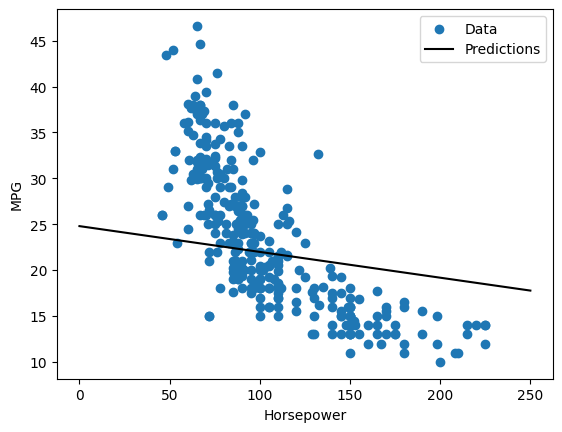

In [ ]:
# Multiple regression model for MPG data set.

# Install Seaborn
!pip install -q seaborn # package installer for non-standard libraries
                        # The ! allows you to run shell commands form an interactive notebook.

import matplotlib.pyplot as plt # for visualizing data
import numpy as np # Supports arrays in Python
import pandas as pd # data manipulation
import seaborn as sns # Data visualization library built on top of matplotlib

np.set_printoptions(precision=3, suppress=True) # Print numpy arrays to 3 decimal places.  Suppresses scientific notation.

import tensorflow as tf
from tensorflow.keras import layers

# MPG database
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']


# Reads data from a .csv file and converts it to a Dataframe.
raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset = raw_dataset.copy()

# Check for missing values - there are 6
dataset.isna().sum()

# Drop rows with missing values
dataset = dataset.dropna()

# Convert the values 1, 2, 3 in the data for the country to country names.
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

# Converts the countries into 3 columns of 1s and 0s.
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')


train_dataset = dataset.sample(frac=0.8, random_state=0) # Randomly select 80% of the rows.
test_dataset = dataset.drop(train_dataset.index) # Remove the training data to get the test data.

#sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

#print(train_dataset.describe().transpose()) # Print summary statistics about each column

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG') # Remove and return the MPG column from the training data.
test_labels = test_features.pop('MPG') # Remove and return the MPG column from the test data.

train_features = train_features.astype(np.float32) # Convert the data type to float.  The adapt function errors out if there are integers in the data.

# normalizer = tf.keras.layers.Normalization(axis=-1)


#normalizer.adapt(np.array(train_features))  # Calculates the mean and variance of each column in the dataset.
                                             # This is needed to pass to the Normalization layer.

#hp=np.array(train_features['Horsepower']) # Pull out the hp column from the training data.

normalizer = layers.Normalization(input_shape=[1,], axis=None)  # Create a normalization layer, this shifts and scales the inputs
                                                                   # so they are centered at zero and stdev = 1

normalizer.adapt(train_features) # Calculate the mean and variance of the hp column

# Create the regression model.
model = tf.keras.Sequential([
    normalizer,              # Normalizes the input
    layers.Dense(units=1)       # A Linear layer with 1 output.  output = weight * input + bias
])

model.summary()

# hp_model.predict(hp[:10])

# The compile method configures the model for training. Assigns the optimizer with learning rate, loss function, and metrics to keep track of during training
# Optimizers -> Many including Adam, RMSprop, and SGD
# Loss functions -> Many including BinaryCrossentropy, CategoricalCrossentropy, MeanSquaredError
# Metrics -> Many including Accuaracy,
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

# Model.fit trains the model.  Returns a history object which contains a record of the training and validation loss and metrics for each epoch.
history = model.fit(
    train_features['Horsepower'], # Input data x.  Can be a numpy array, tensor, or a dataset
    train_labels,                 # Expected outputs y.  Can be a numpy array, tensor, or a dataset
    epochs=100,                   # Number of times to run through training data.
    verbose=2,                    # 0 = silent, 1 = progress bar for each epoch, 2 = shows loss for each epoch
    validation_split = 0.2)       # Fraction of the training data to be used for validation

#hist = pd.DataFrame(history.history) # The history attribute of the history object returned by the fit method contains the training results for each epoch.
#hist['epoch'] = history.epoch
#print(hist)

# Create a function to plot a graph of the loss by epoch
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

#plot_loss(history)

test_results = {}

# The model.evaluate function return the loss and metrics from testing the model.
test_results['model'] = model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

x = tf.linspace(0.0, 250, 251) # Create a set of input data for a plot
y = model.predict(x) # The predict method makes predictions from the model based on input data.

# Create a function to plot actual vs. predicted values for the model.
def plot_hp(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

plot_hp(x, y)
